In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from PIL import Image
import os


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [132]:
# ORIGINAL DATA FRPM CIFAR10
def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed = 1,
                           split_ratio=0.1,
                           shuffle=True):
    normalize = transforms.Normalize( mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

    # define transforms
 
    transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])


    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )
    torch.manual_seed(random_seed)
    

    num_samples = len(train_dataset) 
    indices = list(range(num_samples))
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
 
    split = int(np.floor(split_ratio * num_samples))

    train_indices = indices[:split]
    valid_indices = indices[split:]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)

    train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64,
    sampler=train_sampler, num_workers=2
)

    valid_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64,
        sampler=valid_sampler, num_workers=2
    )

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
    torch.manual_seed(1)
    # define transform
    transform = transforms.Compose([        
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize
    ])


    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )



    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )


    return (data_loader, dataset.classes)



train_loader, valid_loader = get_train_valid_loader(data_dir = './data', batch_size = 64, random_seed = 1)

test_loader, classes = get_test_loader(data_dir = './data', batch_size = 64, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# LOW RESOLUTION DATA


data_path = 'data/low_res'

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.imgs = os.listdir(root)
        
    def __getitem__(self, index):
        img_path = os.path.join(self.root, self.imgs[index])
        img = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = int(self.imgs[index].split('_')[1])
        
        return img, label
    
    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = CustomDataset(data_path, transform=data_transform)


train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1


train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size


train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)


In [6]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

48000
6000
6000


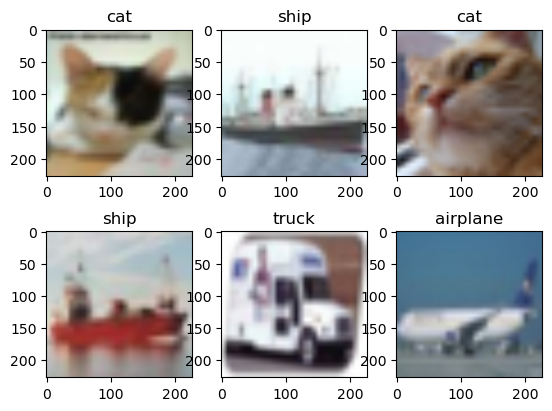

In [133]:

data_iter = iter(train_loader)
images, labels = next(data_iter)
denormalize = transforms.Normalize(mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std])
for i in range(6):
    plt.subplot(2,3,i+1)   
    mean=[0.4914, 0.4822, 0.4465]
    std=[0.2023, 0.1994, 0.2010]
    denormalized_image = denormalize(images[i]).numpy()
    image  = np.transpose(denormalized_image, (1, 2, 0))
    plt.imshow(image)
    plt.title(classes[labels[i].item()])

In [134]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [135]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

In [136]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/20], Step [79/79], Loss: 1.9914
Accuracy of the network on the 5000 validation images: 37.477777777777774 %
Epoch [2/20], Step [79/79], Loss: 1.2408
Accuracy of the network on the 5000 validation images: 44.257777777777775 %
Epoch [3/20], Step [79/79], Loss: 1.7480


KeyboardInterrupt: 